In [40]:
from pathlib import Path
import sys

print("CWD:", Path.cwd())

PROJECT_ROOT = Path.cwd().parent     
SRC_DIR = PROJECT_ROOT / "src"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR exists:", SRC_DIR.exists())

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("dsvm in sys.path now:", any("src" in p and "dsvm-dtw" in p for p in sys.path))

CWD: c:\Users\siam2\Desktop\dsvm-dtw\experiments
PROJECT_ROOT: c:\Users\siam2\Desktop\dsvm-dtw
SRC_DIR exists: True
dsvm in sys.path now: True


In [41]:
# Phase I: Bootstrap 기반 control limit 설계
# dsvm_phase1_control_limit.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dsvm.arl_mcc import estimate_arl_for_h_mcc

In [42]:
# 프로젝트 루트 및 결과 디렉토리 설정
THIS_NOTEBOOK = Path().resolve()
PROJECT_ROOT = THIS_NOTEBOOK.parent   # dsvm-dtw/
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
CONTROL_DIR = RESULTS_DIR / "control_limits"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
CONTROL_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RESULTS_DIR :", RESULTS_DIR)
print("TABLES_DIR  :", TABLES_DIR)
print("CONTROL_DIR :", CONTROL_DIR)

# 데이터셋 / 실험 설정
dataset = "ECG5000"
stream = "train_incontrol"
mode = "ecd"         
data_version = "shift40"
seed = 10
m = 100               
target_arl0 = 20

# 병합이 완료된 bootstrap p_swk 파일 범위
rep_start = 0
rep_end = 999   # 예: 0~199 → rep_0 ~ rep_199

PROJECT_ROOT: C:\Users\siam2\Desktop\dsvm-dtw
RESULTS_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results
TABLES_DIR  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables
CONTROL_DIR : C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits


In [43]:
# Phase I 데이터프레임 불러오기
file_name = (
    f"{dataset}_{stream}_p_swk_matrix_{mode}_{data_version}"
    f"({rep_start}~{rep_end})_bootstrap_seed{seed}_m={m}.csv"
)
file_path = TABLES_DIR / file_name

print("읽을 파일명:", file_name)
print("전체 경로  :", file_path)

# 't'를 index로 복구
df_pswk = pd.read_csv(file_path, index_col=0)
print("df_pswk.shape:", df_pswk.shape)
df_pswk.head()

읽을 파일명: ECG5000_train_incontrol_p_swk_matrix_ecd_shift40(0~999)_bootstrap_seed10_m=100.csv
전체 경로  : C:\Users\siam2\Desktop\dsvm-dtw\results\tables\ECG5000_train_incontrol_p_swk_matrix_ecd_shift40(0~999)_bootstrap_seed10_m=100.csv
df_pswk.shape: (100, 1000)


,rep_0,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,...,rep_990,rep_991,rep_992,rep_993,rep_994,rep_995,rep_996,rep_997,rep_998,rep_999
t,,,,,,,,,,,,,,,,,,,,,
0,0.318332,0.313744,0.313575,0.301259,0.324974,0.335232,0.346600,0.310616,0.304299,0.309340,...,0.302573,0.303487,0.311113,0.308462,0.309364,0.325205,0.299147,0.317548,0.306483,0.294789
1,0.301266,0.305619,0.326453,0.312939,0.313134,0.307753,0.304906,0.304701,0.315975,0.323327,...,0.313030,0.306110,0.299925,0.300344,0.325218,0.342824,0.297985,0.301961,0.301192,0.285057
2,0.298234,0.293292,0.300551,0.316690,0.295422,0.304432,0.310153,0.333556,0.307680,0.310519,...,0.284621,0.315320,0.325210,0.294416,0.309669,0.317057,0.295429,0.311997,0.302622,0.338235
3,0.302672,0.303012,0.333002,0.306375,0.302782,0.306121,0.309027,0.308133,0.306998,0.308844,...,0.308306,0.311375,0.323649,0.286044,0.423676,0.342670,0.302075,0.306514,0.302007,0.312460
4,0.311012,0.307122,0.316225,0.311710,0.296271,0.309883,0.311248,0.332266,0.327381,0.323090,...,0.319682,0.315256,0.334264,0.315673,0.352493,0.340611,0.301759,0.328275,0.305796,0.299942


In [44]:
p_swk_mat = df_pswk.values  # shape (m, outer_reps)

print("p_swk min :", p_swk_mat.min())
print("p_swk max :", p_swk_mat.max())

# 아주 넓은 구간에서 coarase grid
h_grid_coarse = np.linspace(p_swk_mat.min(), p_swk_mat.max(), 20)

rows = []
for h in h_grid_coarse:
    est = estimate_arl_for_h_mcc(h=h, p_swk_mat=p_swk_mat, m=m)
    rows.append({"h": h, "ARL0": est["arl"]})

df_scan = pd.DataFrame(rows)
df_scan


p_swk min : 0.2813273457959264
p_swk max : 0.4725410508708612


,h,ARL0
0,0.281327,1.000000
1,0.291391,1.039000
2,0.301455,1.371000
3,0.311519,3.016000
4,0.321583,9.306533
5,0.331647,27.159389
6,0.341711,58.824468
7,0.351775,117.367159
8,0.361838,228.985207
9,0.371902,420.765854


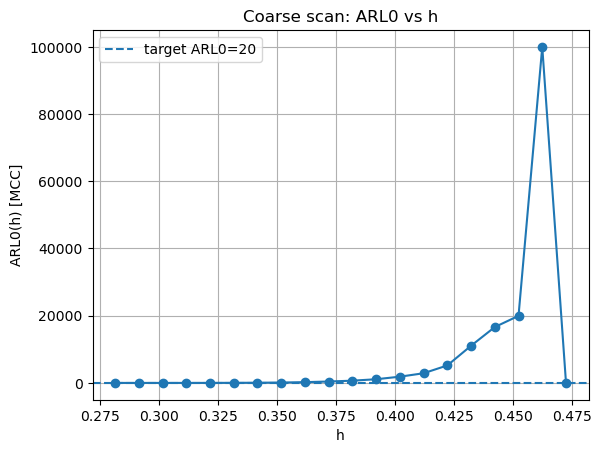

In [45]:
plt.plot(df_scan["h"], df_scan["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Coarse scan: ARL0 vs h")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# diff = ARL0 - target
df_scan["diff"] = df_scan["ARL0"] - target_arl0
df_scan

,h,ARL0,diff
0,0.281327,1.000000,-19.000000
1,0.291391,1.039000,-18.961000
2,0.301455,1.371000,-18.629000
3,0.311519,3.016000,-16.984000
4,0.321583,9.306533,-10.693467
5,0.331647,27.159389,7.159389
6,0.341711,58.824468,38.824468
7,0.351775,117.367159,97.367159
8,0.361838,228.985207,208.985207
9,0.371902,420.765854,400.765854


In [47]:
brackets = []

for i in range(len(df_scan) - 1):
    h1, a1, d1 = df_scan.loc[i, ["h", "ARL0", "diff"]]
    h2, a2, d2 = df_scan.loc[i+1, ["h", "ARL0", "diff"]]

    # sign change 여부 확인
    if d1 == 0:
        brackets.append((h1, h1))
    elif d1 * d2 < 0:
        brackets.append((h1, h2))

brackets


[(0.3215828626538074, 0.33164674186827764)]

In [48]:
if len(brackets) == 0:
    print("경고: coarse grid에서 target ARL0를 가로지르는 구간을 찾지 못했습니다.")
    print("→ h 범위를 넓히거나, coarse grid 개수를 늘려서 다시 확인하는 게 좋습니다.")
    # 그래도 진행하고 싶다면, 그냥 전체 범위에서 best gap를 찾는 fallback을 만들 수도 있음
else:
    h_low, h_high = brackets[0]
    print(f"선택된 브래킷 구간: h_low = {h_low:.6f}, h_high = {h_high:.6f}")


선택된 브래킷 구간: h_low = 0.321583, h_high = 0.331647


In [49]:
target_arl = target_arl0
tolerance = 0.01
max_iter = 50  # coarse 브래킷 안이므로 너무 많이 안 돌려도 됨

lower = h_low
upper = h_high

best_h = None
best_arl = None
best_gap = float('inf')
best_sdrl = None
best_se = None

for _ in range(max_iter):
    mid = (lower + upper) / 2
    res = estimate_arl_for_h_mcc(mid, p_swk_mat, m)
    est_arl = res['arl']
    gap = abs(est_arl - target_arl)

    if gap < best_gap:
        best_gap = gap
        best_h = mid
        best_arl = est_arl
        best_sdrl = res['sdrl']
        best_se = res['se']

    if gap < tolerance:
        break

    # ARL가 target보다 작으면 → threshold가 너무 낮은 것 → 더 크게
    if est_arl < target_arl:
        lower = mid
    else:
        upper = mid

print(f"\n✅ 최적 h ≈ {best_h:.6f}")
print(f"   추정 ARL0(h*) ≈ {best_arl:.3f} (target={target_arl})")
print(f"   SDRL(h*)      ≈ {best_sdrl:.3f}")
print(f"   SE[ARL0(h*)]  ≈ {best_se:.4f}")
print(f"   최종 gap      ≈ {best_gap:.4f}")



✅ 최적 h ≈ 0.328227
   추정 ARL0(h*) ≈ 20.008 (target=20)
   SDRL(h*)      ≈ 32.627
   SE[ARL0(h*)]  ≈ 1.0318
   최종 gap      ≈ 0.0084


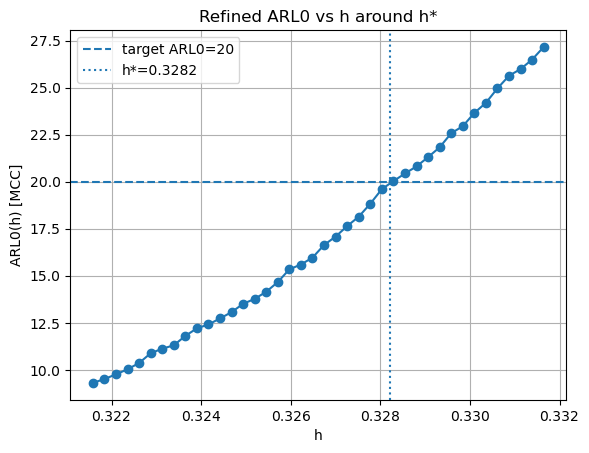

In [50]:
# 브래킷 주변을 조금 더 촘촘하게 보자
h_fine = np.linspace(h_low, h_high, 40)
rows_fine = []
for h in h_fine:
    est = estimate_arl_for_h_mcc(h, p_swk_mat, m)
    rows_fine.append({"h": h, "ARL0": est["arl"]})

df_fine = pd.DataFrame(rows_fine)

plt.plot(df_fine["h"], df_fine["ARL0"], marker="o")
plt.axhline(target_arl0, linestyle="--", label=f"target ARL0={target_arl0}")
plt.axvline(best_h, linestyle=":", label=f"h*={best_h:.4f}")
plt.xlabel("h")
plt.ylabel("ARL0(h) [MCC]")
plt.title("Refined ARL0 vs h around h*")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
import json

#h*만 npy로 저장
h_star = float(best_h)
h_star_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.npy"
np.save(h_star_path, np.array([h_star], dtype=float))
print("h* 저장 경로 (npy):", h_star_path)

# 메타정보 json 저장
meta = {
    "dataset": dataset,
    "stream": stream,
    "mode": mode,
    "data_version": data_version,
    "seed": seed,
    "m": m,
    "target_ARL0": target_arl0,
    "h_star": float(best_h),
    "ARL0_h_star": float(best_arl),
    "SDRL_h_star": float(best_sdrl),
    "SE_ARL0_h_star": float(best_se),
    "rep_start": int(rep_start),
    "rep_end": int(rep_end),
}

h_star_json_path = CONTROL_DIR / f"{dataset}_{stream}_h_star_{mode}_{data_version}_bootstrap_seed{seed}_m={m}.json"
with open(h_star_json_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("h* 메타정보 json 저장 경로:", h_star_json_path)


h* 저장 경로 (npy): C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_shift40_bootstrap_seed10_m=100.npy
h* 메타정보 json 저장 경로: C:\Users\siam2\Desktop\dsvm-dtw\results\control_limits\ECG5000_train_incontrol_h_star_ecd_shift40_bootstrap_seed10_m=100.json


In [52]:
# 추후 Phase II에서 사용할 때는 
# h_star = float(np.load(h_star_path))